In [24]:
import albumentations as A
import torch
import os
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp

from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from dataloaders import BalloonDatasetSegmentation, BalloonLoaders
from json_to_masks import create_labels
from utils import *

## Create masks

In [25]:
create_labels('train')
create_labels('val')

## Augmentations

In [26]:
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        
        
        A.RandomCrop(height=512, width=512, p=1),
        A.ShiftScaleRotate(scale_limit=0.5, 
                            rotate_limit=0.1, 
                            shift_limit=0.2, 
                            p=1, 
                            border_mode=0),
        A.GaussNoise (p=0.1),
        A.Perspective(p=0.5),
        
        # Мы хотим, чтобы шарики сегментировались, не на основе цвета, а на основе формы
        # Поэтому добавим перемешивание каналов
        A.OneOf(
            [
                
                A.ChannelShuffle(p=1),
        
                A.OneOf(
                    [
                        A.CLAHE(p=1),
                        A.RandomBrightness(p=1),
                        A.RandomGamma(p=1),
                    ],
                    p=0.9,
                ),

                A.OneOf(
                    [
                        A.RandomBrightnessContrast(p=1),
                        A.HueSaturationValue(p=1),
                    ],
                    p=0.9,
                ),
            ]
        )
        
    ]
    return A.Compose(train_transform)

In [27]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps=1., activation = None),
]

In [28]:
class My_network():
    
    
    def __init__(self, loss, metrics):
        self.model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=1, 
            activation=ACTIVATION,
        )
        
        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=0.0001),
        ])
        
        self.train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer= self.optimizer,
            device=DEVICE,
            verbose=False,
        )

        self.valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=False,
        )
        
        
    def run_training(self, loaders, n_epochs=40, save_name='./best_model.pth'):
        max_score = 0
        for i in range(0, n_epochs):

            train_logs = self.train_epoch.run(loaders.train_loader)
            valid_logs = self.valid_epoch.run(loaders.valid_loader)

            if i%10==0: 
                print(f'==Epoch {i}==')
                print('Train/Val IoU:')
                print(round(train_logs['iou_score'] , 2))
                print(round(valid_logs['iou_score'] , 2))

            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, save_name)
    
    def eval(self, dataloader, model_path='./best_model.pth'):
        best_model = torch.load(model_path)
        test_epoch = smp.utils.train.ValidEpoch(
                         model=best_model,
                         loss=loss,
                         metrics=metrics,
                         device=DEVICE,
                         verbose=True
                      )

        logs = test_epoch.run(dataloader)
        return best_model

In [29]:
network = My_network(loss, metrics)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example image and mask:


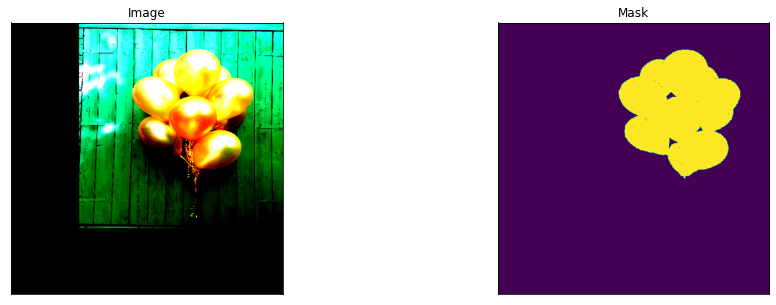

Training model:
==Epoch 0==
Train/Val IoU:
0.09
0.13
==Epoch 10==
Train/Val IoU:
0.75
0.68
==Epoch 20==
Train/Val IoU:
0.85
0.77
==Epoch 30==
Train/Val IoU:
0.84
0.84
Eval model:
valid: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s, dice_loss - 0.281, iou_score - 0.7596] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


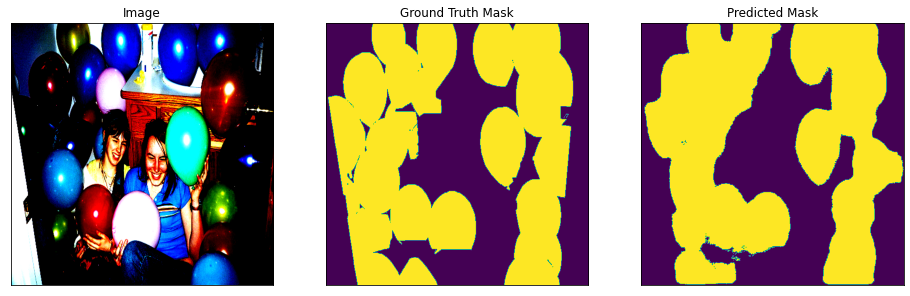

In [30]:
balloon_loaders = BalloonLoaders(augmentation=get_training_augmentation(), 
                                 preprocessing_fn=preprocessing_fn)
print("Example image and mask:")
balloon_loaders.show_example()

print("Training model:")
network.run_training(balloon_loaders, n_epochs=40)

print("Eval model:")
best_model = network.eval(balloon_loaders.test_loader)
compare_predictions(balloon_loaders, best_model)

## Without augmentations

Training model:
==Epoch 0==
Train/Val IoU:
0.13
0.09
==Epoch 10==
Train/Val IoU:
0.46
0.36
==Epoch 20==
Train/Val IoU:
0.66
0.65
==Epoch 30==
Train/Val IoU:
0.85
0.81
Eval model:
valid: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s, dice_loss - 0.2871, iou_score - 0.8327]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


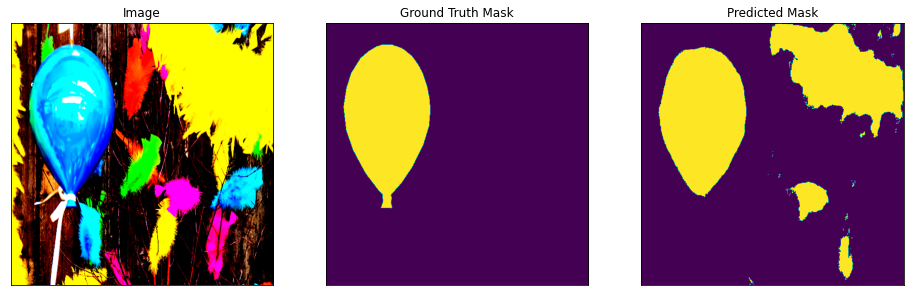

In [31]:
network_without_aug = My_network(loss, metrics)
balloon_loaders = BalloonLoaders(augmentation=None, preprocessing_fn=preprocessing_fn)

print("Training model:")
network_without_aug.run_training(balloon_loaders, n_epochs=40, 
                                 save_name='./best_model_without_aug.pth')

print("Eval model:")
best_model = network_without_aug.eval(balloon_loaders.test_loader, 
                                      model_path='./best_model_without_aug.pth')
compare_predictions(balloon_loaders, best_model)

## Вывод:

### Для примера был взят датасет  Balloons. В работе решил использовать библиотеку albumentations. Поигрался с параметрами изменения цвета, добавление Гауссовского шума, эквализация  гистограм и т.д. В целом использование различных аугментаций не принесло значимых результатов. Обычно оно было такое же, как и без них, либо чуть хуже (где-то на 5 пунток IoU). Скорее всего это связано с тем, что сам датасет представлен в различных контекстах, поэтому аугментации не делают результаты лучше.